In [1]:
import pandas as pd
import ftplib
import isd_parse
import gzip
import io

In [15]:
ftp = ftplib.FTP('ftp.ncdc.noaa.gov')
ftp.login()

'230-****** WARNING ** WARNING ** WARNING ** WARNING ** WARNING ******\n ** This is a United States Department of Commerce computer     **\n ** system, which may be accessed and used only for             **\n ** official Government business by authorized personnel.       **\n ** Unauthorized access or use of this computer system may      **\n ** subject violators to criminal, civil, and/or administrative **\n ** action.  All information on this computer system may be     **\n ** intercepted, recorded, read, copied, and disclosed by and   **\n ** to authorized personnel for official purposes, including    **\n ** criminal investigations.  Access or use of this computer    **\n ** system by any person, whether authorized or unauthorized,   **\n ** constitutes consent to these terms.                         **\n ****** WARNING ** WARNING ** WARNING ** WARNING ** WARNING ******\n230 Anonymous access granted, restrictions apply'

In [3]:
def get_file(ftp, fname):
    result = bytes()
    def append_to_bytes(bs):
        nonlocal result
        result += bs
    ftp.retrbinary('RETR {}'.format(fname), append_to_bytes)
    return result

In [4]:
ftp.cwd('/pub/data/noaa/')
isd_history = get_file(ftp, 'isd-history.csv')

In [5]:
with io.StringIO(isd_history.decode()) as f:
    stations_df = pd.read_csv(f)
print(stations_df.shape)
stations_df.head()

(29744, 11)


,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
0,007018,99999,WXPOD 7018,NaN,NaN,NaN,0.00,0.000,7018.0,20110309,20130730
1,007026,99999,WXPOD 7026,AF,NaN,NaN,0.00,0.000,7026.0,20120713,20170822
2,007070,99999,WXPOD 7070,AF,NaN,NaN,0.00,0.000,7070.0,20140923,20150926
3,008260,99999,WXPOD8270,NaN,NaN,NaN,0.00,0.000,0.0,20050101,20100920
4,008268,99999,WXPOD8278,AF,NaN,NaN,32.95,65.567,1156.7,20100519,20120323


In [6]:
mask = stations_df.STATE == 'CA'
print(stations_df[mask].shape)
stations_df[mask].head()

(509, 11)


,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
14464,690020,93218,JOLON HUNTER LIGGETT MIL RES,US,CA,KHGT,36.000,-121.233,317.0,19640715,19970401
14465,690020,99999,JOLON HUNTER LIGGETT MIL RES,US,CA,KHGT,36.000,-121.233,317.0,20030702,20030801
14466,690070,93217,FRITZSCHE AAF,US,CA,KOAR,36.683,-121.767,43.0,19600404,19930831
14467,690080,99999,TARIN KOWT,AF,CA,KQA7,32.600,65.870,1380.0,20030616,20030624
14473,690140,93101,EL TORO MCAS,US,CA,KNZJ,33.667,-117.733,116.7,19890101,19990630


In [7]:
ids = stations_df[mask].USAF.astype(str) + "-" + stations_df[mask].WBAN.astype(str)
ids.head()

14464    690020-93218
14465    690020-99999
14466    690070-93217
14467    690080-99999
14473    690140-93101
dtype: object

In [16]:
ftp.cwd('/pub/data/noaa/2019/')
files = list(ftp.nlst())

In [17]:
print(len(files))
ca_files = [fn for fn in files if fn[:12] in ids.values]
print(len(ca_files))

13500
139


In [18]:
%%time
raw_files = [get_file(ftp, fname) for fname in ca_files]

Wall time: 3min 57s


In [19]:
%%time
raw_files = [gzip.decompress(f) for f in raw_files]

Wall time: 3.12 s


In [20]:
%%time
lines = [isd_parse.parse_isd_line(line)
         for rf in raw_files
         for line in rf.decode('ascii').split("\n") if line]
df = pd.DataFrame(data=lines)

Wall time: 52.8 s


In [21]:
print(df.shape)
df.head()

(2128659, 11)


,var_data_len,usaf_station_id,wban_station_id,date,latitude,longitude,report_type,elevation_meters,call_letters,qc_process,air_temp_c
0,191,723930,93214,2019-01-01 00:58:00,34.717,-120.566,FM-15,112.0,KVBG,V02,10.4
1,179,723930,93214,2019-01-01 01:58:00,34.717,-120.566,FM-15,112.0,KVBG,V02,9.0
2,196,723930,93214,2019-01-01 02:58:00,34.717,-120.566,FM-15,112.0,KVBG,V02,9.2
3,134,723930,93214,2019-01-01 03:58:00,34.737,-120.584,FM-15,112.0,None,V02,8.5
4,175,723930,93214,2019-01-01 04:58:00,34.717,-120.566,FM-15,112.0,KVBG,V02,8.1


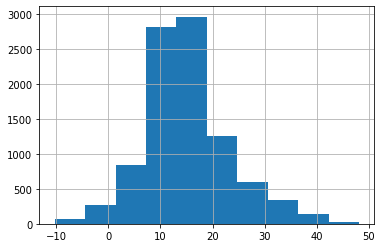

In [23]:
%matplotlib inline
df.sample(10000).air_temp_c.hist()

In [24]:
df.to_csv('noaa_isd_data.csv')